## Introduction
In this project, we aim to classify cardiac magnetic resonance imaging (CMRI) images into five different diagnostic classes, including healthy controls, myocardial infarction, dilated cardiomyopathy, hypertrophic cardiomyopathy, and abnormal right ventricle. The classification is based on features extracted from the MRI images, such as the volume of anatomical structures at two different time points in the cardiac cycle, the thickness of the cardiac muscle, and the ejection fractions. Machine learning algorithms are then used to classify the subjects into the five diagnostic classes.

We have been provided with a dataset of 150 subjects with their corresponding MRI images, segmentations, and metadata. The data has been randomly split into a training-validation set with 100 subjects and a test set with 50 subjects. The training-validation set contains the classification labels made by clinicians, while the test set does not.

The dataset has two MRI images for each subject, one at the end of diastole (end of dilation in the cardiac cycle) and one at the end of systole (end of contraction). The MRI images are 3D volumes containing the heart and adjacent structures. Additionally, for each image in the training-validation set, a corresponding 3D segmentation of the cardiac anatomy is provided, including left ventricle cavity, right ventricle cavity, and myocardium. The segmentation map consists of a 3D multi-label mask with the corresponding labels.

To classify the test set, we could optionally perform a left ventricle segmentation. I opted to complete the missing part inside the myocardium instead.
The project's goal is to identify cardiac pathologies early to guide treatment and prevent complications, such as heart failure and sudden cardiac arrest. Our approach for automatic diagnosis from cardiac magnetic resonance imaging (CMRI) will be a non-invasive computer-aided diagnosis (CAD) based on the extracted features and machine learning algorithms.

In [ ]:
!pip install -q nibabel # The -q option stands for quiet (to not show the pip install process)

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as morphology

import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import gdown

url = 'https://drive.google.com/file/d/132l_ArOZelCV4f-QF4oQgoXN_U_JD1_0/view?usp=share_link'
output_path = 'ima205-challenge-2023.zip'
gdown.download(url, output_path, quiet=False,fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=132l_ArOZelCV4f-QF4oQgoXN_U_JD1_0
To: /content/ima205-challenge-2023.zip
100%|██████████| 160M/160M [00:03<00:00, 52.0MB/s]


'ima205-challenge-2023.zip'

In [ ]:
!unzip ./ima205-challenge-2023.zip

Archive:  ./ima205-challenge-2023.zip
  inflating: SampleSubmission.csv    
  inflating: Test/101/101_ED.nii     
  inflating: Test/101/101_ED_seg.nii  
  inflating: Test/101/101_ES.nii     
  inflating: Test/101/101_ES_seg.nii  
  inflating: Test/102/102_ED.nii     
  inflating: Test/102/102_ED_seg.nii  
  inflating: Test/102/102_ES.nii     
  inflating: Test/102/102_ES_seg.nii  
  inflating: Test/103/103_ED.nii     
  inflating: Test/103/103_ED_seg.nii  
  inflating: Test/103/103_ES.nii     
  inflating: Test/103/103_ES_seg.nii  
  inflating: Test/104/104_ED.nii     
  inflating: Test/104/104_ED_seg.nii  
  inflating: Test/104/104_ES.nii     
  inflating: Test/104/104_ES_seg.nii  
  inflating: Test/105/105_ED.nii     
  inflating: Test/105/105_ED_seg.nii  
  inflating: Test/105/105_ES.nii     
  inflating: Test/105/105_ES_seg.nii  
  inflating: Test/106/106_ED.nii     
  inflating: Test/106/106_ED_seg.nii  
  inflating: Test/106/106_ES.nii     
  inflating: Test/106/106_ES_seg.nii  


In [ ]:
working_directory= "."

In [ ]:
# Visualizing a sample of systole and diastole
ED = nib.load(working_directory + '/Train/100/100_ED.nii').get_fdata()
ES = nib.load(working_directory + '/Train/100/100_ES.nii').get_fdata()
print(f'Diastole sample shape: {ED.shape}')
print(f'Systole sample shape: {ES.shape}')

Diastole sample shape: (216, 304, 8)
Systole sample shape: (216, 304, 8)


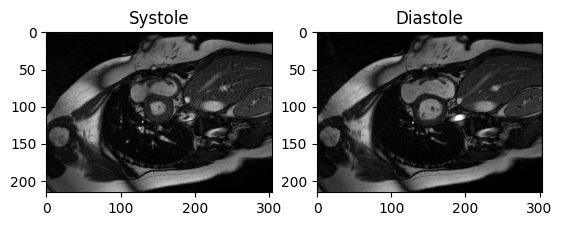

In [ ]:
sliceSys = ES[:,:,1]
sliceDia = ED[:,:,1]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sliceSys, cmap='gray')
ax[0].set_title('Systole')
ax[1].imshow(sliceDia, cmap='gray')
ax[1].set_title('Diastole')
plt.show()

In [ ]:
# Visualizing a segmentation
id = 100
assert id <= 100 and id > 0, "The id for train must be between 1 and 100"
id = "{0:0=3d}".format(id)
ED_seg = nib.load(working_directory + '/Train/'+id+'/'+id+'_ED_seg.nii').get_fdata()
ES_seg = nib.load(working_directory + '/Train/'+id+'/'+id+'_ES_seg.nii').get_fdata()
print(f'Diastole sample shape: {ED_seg.shape}')
print(f'Systole sample shape: {ES_seg.shape}')

Diastole sample shape: (216, 304, 8)
Systole sample shape: (216, 304, 8)


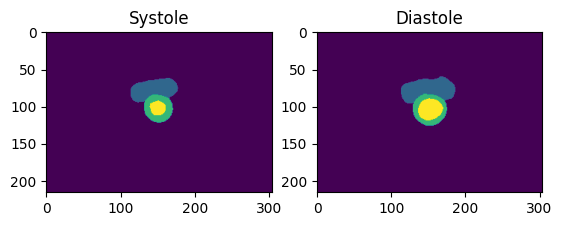

In [ ]:
sliceSys = ES_seg[:,:,1]
sliceDia = ED_seg[:,:,1]
fig, ax = plt.subplots(1, 2)
ax[0].imshow(sliceSys)
ax[0].set_title('Systole')
ax[1].imshow(sliceDia)
ax[1].set_title('Diastole')
plt.show()

In [ ]:
# Taking a look at the segmentations in the test set
id = 105
assert id > 100 and id <= 150, "The id for test must be between 101 and 150"
id = str(id)
ED_seg = nib.load(working_directory + '/Test/'+id+'/'+id+'_ED_seg.nii').get_fdata()
ES_seg = nib.load(working_directory + '/Test/'+id+'/'+id+'_ES_seg.nii').get_fdata()
print(f'Diastole sample shape: {ED_seg.shape}')
print(f'Systole sample shape: {ES_seg.shape}')

Diastole sample shape: (168, 208, 21)
Systole sample shape: (168, 208, 21)


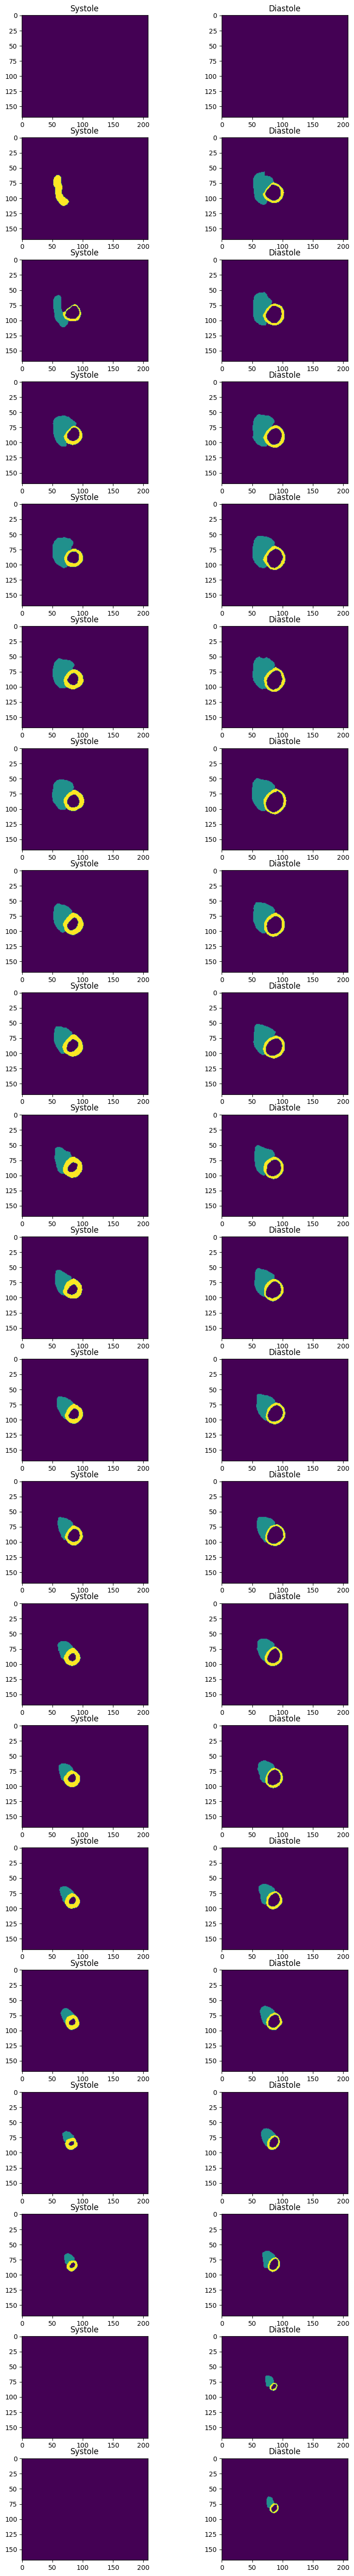

In [ ]:
slicesSys = ES_seg[:,:,:]
slicesDia = ED_seg[:,:,:]
fig, ax = plt.subplots(slicesSys.shape[2], 2, figsize=(10,70))
for i in range(slicesSys.shape[2]):
  ax[i][0].imshow(slicesSys[:,:,i])
  ax[i][0].set_title('Systole')
  ax[i][1].imshow(slicesDia[:,:,i])
  ax[i][1].set_title('Diastole')

We can see that filling up the holes of the segmentation is enough to find the left ventricle segmentation. To do so I will remove in a temporary image the right ventriculum segmentation and do a binary filling of the myocardium.
The background of the image is labeled with 0s, the right ventricle with 1s, the myocardium is labeled with 2s and the left with 3s (for train imgs).

In [ ]:
def segment_left_ventricle(partially_seg_img):
  img = partially_seg_img.copy()
  img[img == 1] = 0 # Removing the right ventricle
  if (img.max() != 0):
    img = img/img.max() # normalizing
  img_filled = morphology.binary_fill_holes(img)
  left_ventriculum = img_filled - img
  left_ventriculum = left_ventriculum * 3
  fully_segmented_img = left_ventriculum + partially_seg_img.copy()
  return fully_segmented_img

In [ ]:
# Taking a look at the segmentations in the test set
id = 105
assert id > 100 and id <= 150, "The id for test must be between 101 and 150"
id = str(id)
ED_seg = nib.load(working_directory + '/Test/'+id+'/'+id+'_ED_seg.nii').get_fdata()
ES_seg = nib.load(working_directory + '/Test/'+id+'/'+id+'_ES_seg.nii').get_fdata()
print(f'Diastole sample shape: {ED_seg.shape}')
print(f'Systole sample shape: {ES_seg.shape}')

Diastole sample shape: (168, 208, 21)
Systole sample shape: (168, 208, 21)


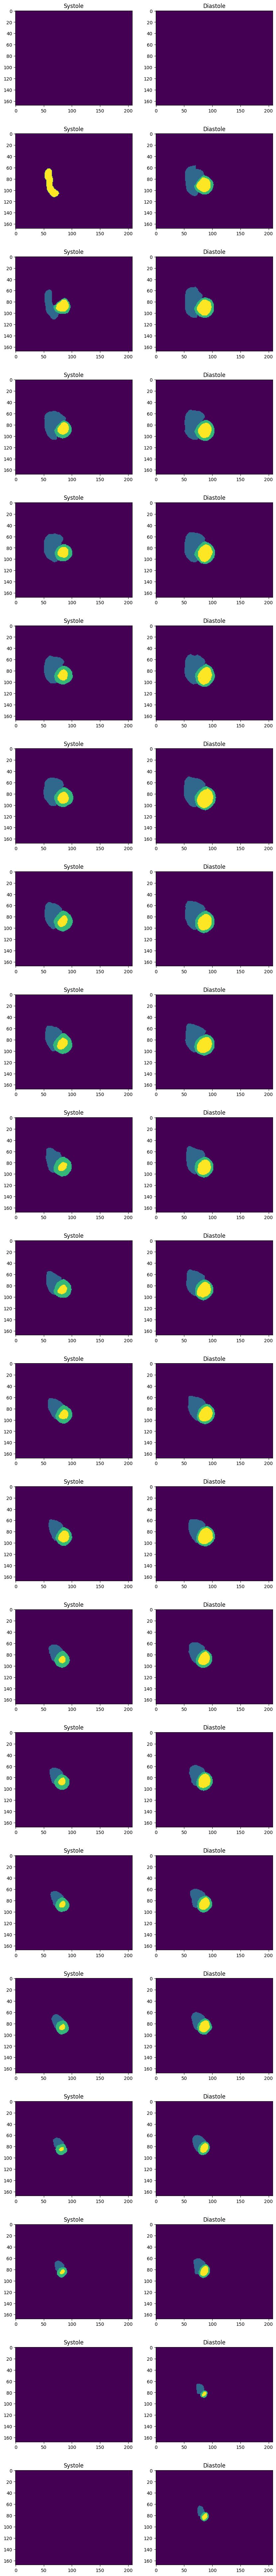

In [ ]:
slicesSys = ES_seg[:,:,:]
slicesDia = ED_seg[:,:,:]
fig, ax = plt.subplots(slicesSys.shape[2], 2, figsize=(10,100))
for i in range(slicesSys.shape[2]):
  imgSys = segment_left_ventricle(slicesSys[:,:,i])
  imgDia = segment_left_ventricle(slicesDia[:,:,i])
  ax[i][0].imshow(imgSys)
  ax[i][0].set_title('Systole')
  ax[i][1].imshow(imgDia)
  ax[i][1].set_title('Diastole')

Now creating a function to do the segmentation for a given id.

In [ ]:
def segment_all_left_ventricle_slices(id):
  assert id > 100 and id <= 150, "The id for test must be between 101 and 150"
  id = str(id)
  ED_seg = nib.load(working_directory + '/Test/'+id+'/'+id+'_ED_seg.nii').get_fdata()
  ES_seg = nib.load(working_directory + '/Test/'+id+'/'+id+'_ES_seg.nii').get_fdata()
  slicesSys = ES_seg[:,:,:]
  slicesDia = ED_seg[:,:,:]
  imgsSys = np.stack([segment_left_ventricle(slicesSys[:,:,i]) for i in range(slicesSys.shape[2])], axis=-1)
  imgsDia = np.stack([segment_left_ventricle(slicesDia[:,:,i]) for i in range(slicesDia.shape[2])], axis=-1)
  return imgsSys, imgsDia

Example of use:

(208, 174, 16)


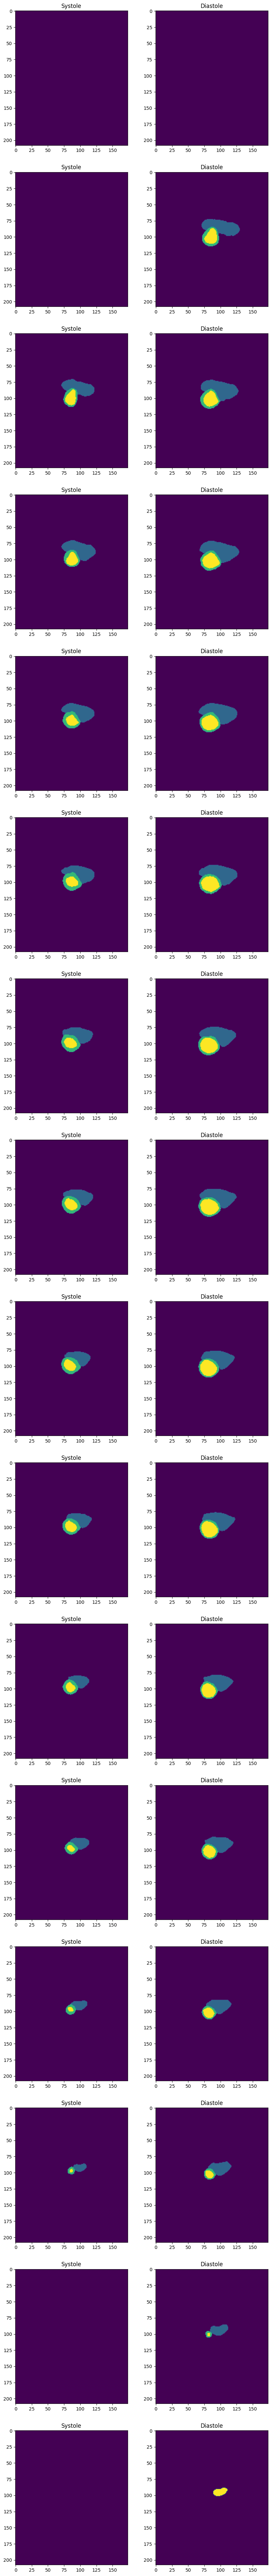

In [ ]:
segmented_slices_sys, segmented_slices_dia = segment_all_left_ventricle_slices(102)
print(segmented_slices_sys.shape)

fig, ax = plt.subplots(segmented_slices_sys.shape[2], 2, figsize=(10,100))
for i in range(segmented_slices_sys.shape[2]):
  ax[i][0].imshow(segmented_slices_sys[:,:,i])
  ax[i][0].set_title('Systole')
  ax[i][1].imshow(segmented_slices_dia[:,:,i])
  ax[i][1].set_title('Diastole')

Since our dataset is quite small, I opted for not using a deep learning technique to learn the images patterns in order to classify it. So, the next step consists in extracting features from the segmentations to use some ML technique.

## Feature Extraction
Initially, let's try to extract the following features:

* Volume of the left ventricle at end systole and end diastoles phases

* Volume of the right ventricle at end systole and end diastole phases

* Ejection fraction of left ventricle and right ventricle

* Mass of the myocardium at end diastole and its volume at end systole

* Patient height and weight


And form our dataset.
Those features were selected because they are present in the majority of papers that describe this heart disease classification task. Also, although I don't have much knowledge in the medical field, these features seen quite reasonable to evaluate the possibility of a heart disease.

Another feature that I tought about inserting is the perimeter of the structures, but I concluded that the perimeter could be too much influenced (because of its geometrical properties) by outliers in the segmentations. As the dataset that I had to compare was small (30% of 50 samples) I opted to just not use it instead of seing its influence empirically.

### Volume of the left ventricle at end systole and end diastoles phases

In order to calculate the volume of our ventricles we will calculate the volume that each pixel of the image represents and sum up. Since we have a small Z resolution this will yield an approximation for the volume. In the header of our nii file we can find the informations about the pixel dimensions.

In [ ]:
# Visualizing the header of a ED file
id = 100
assert id <= 100 and id > 0, "The id for train must be between 1 and 100"
id = "{0:0=3d}".format(id)
ED = nib.load(working_directory + '/Train/'+id+'/'+id+'_ED.nii')
pixel_dimensions = ED.header['pixdim']
print(pixel_dimensions)
ED = ED.get_fdata()

[ 1.       1.31579  1.31579 10.       1.       1.       1.       1.     ]


Now in order to find the volume of the left ventricle associated with one slice we will select only the left ventricle (labeled with 3) and multiply by its dimensions. Let's start by doing it with a slice in the middle.

10.52632470703125


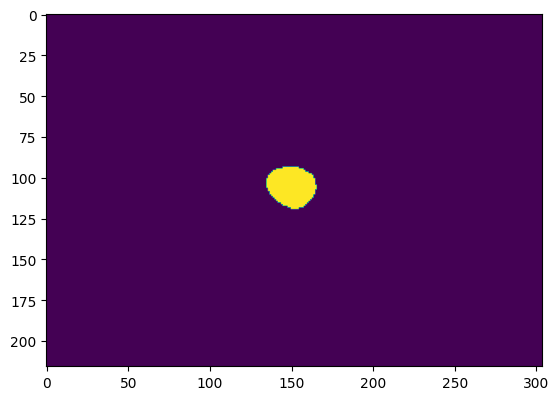

In [ ]:
ED_seg = nib.load(working_directory + '/Train/'+id+'/'+id+'_ED_seg.nii').get_fdata()
ED_seg_slice = ED_seg[:, :, int(ED_seg.shape[2]/2)]
ED_seg_slice[ED_seg_slice != 3] = 0
if (ED_seg_slice.max() != 0):
  ED_seg_slice = ED_seg_slice/ED_seg_slice.max() # Normalize
# The volume associated to each pixel is the product of pixdim[1], pixdim[2], pixdim[3] in mm³
pixel_vol = pixel_dimensions[1] * pixel_dimensions[2] * pixel_dimensions[3]
slice_vol = pixel_vol * np.sum(ED_seg_slice) * 10**-3 # Going to mililiters
print(slice_vol)
plt.imshow(ED_seg_slice)

Doing it for all slices yields:

In [ ]:
ED_seg = nib.load(working_directory + '/Train/'+id+'/'+id+'_ED_seg.nii').get_fdata()
left_ventricle_vol = 0
for i in range(0, ED_seg.shape[2]):
  ED_seg_slice = ED_seg[:, :, i]
  ED_seg_slice[ED_seg_slice != 3] = 0
  if (ED_seg_slice.max() != 0):
    ED_seg_slice = ED_seg_slice/ED_seg_slice.max() # Normalize
  # The volume associated to each pixel is the product of pixdim[1], pixdim[2], pixdim[3] in mm³
  pixel_vol = pixel_dimensions[1] * pixel_dimensions[2] * pixel_dimensions[3]
  left_ventricle_vol += pixel_vol * np.sum(ED_seg_slice) * 10**-3 # Going to mililiters
left_ventricle_vol

71.69327403259278

Now creating a function that returns that end-systolic and end-diastolic volume for a given structure and subject:

In [ ]:
def get_volume(id, structure_index):
  assert id >= 0 and id <= 150, "The id must be between 1 and 150"
  id = "{0:0=3d}".format(id)
  datagroup = 'Train'
  if (int(id) > 100): # Test, we need to do the segmentation
    datagroup = 'Test'
    if (structure_index == 3):
      ES_seg, ED_seg = segment_all_left_ventricle_slices(int(id))
    else:
      ES_seg = nib.load(working_directory + '/' + datagroup + '/'+id+'/'+id+'_ES_seg.nii').get_fdata()
      ED_seg = nib.load(working_directory + '/' + datagroup + '/'+id+'/'+id+'_ED_seg.nii').get_fdata()

  else:
    ES_seg = nib.load(working_directory + '/' + datagroup + '/'+id+'/'+id+'_ES_seg.nii').get_fdata()
    ED_seg = nib.load(working_directory + '/' + datagroup + '/'+id+'/'+id+'_ED_seg.nii').get_fdata()

  # Getting pixels dimensions
  ED = nib.load(working_directory + '/' + datagroup + '/'+id+'/'+id+'_ED.nii')
  pixel_dimensions = ED.header['pixdim']

  ES_structure_vol = 0
  ED_structure_vol = 0

  for i in range(0, ED_seg.shape[2]):
    ES_seg_slice = ES_seg[:, :, i]
    ED_seg_slice = ED_seg[:, :, i]

    ES_seg_slice[ES_seg_slice != structure_index] = 0
    ED_seg_slice[ED_seg_slice != structure_index] = 0
    if (ED_seg_slice.max() != 0):
      ED_seg_slice = ED_seg_slice/ED_seg_slice.max() # Normalize

    if (ES_seg_slice.max() != 0):
      ES_seg_slice = ES_seg_slice/ES_seg_slice.max() # Normalize
    # The volume associated to each pixel is the product of pixdim[1], pixdim[2], pixdim[3] in mm³
    pixel_vol = pixel_dimensions[1] * pixel_dimensions[2] * pixel_dimensions[3]

    ES_structure_vol += pixel_vol * np.sum(ES_seg_slice) * 10**-3 # Going to mililiters
    ED_structure_vol += pixel_vol * np.sum(ED_seg_slice) * 10**-3 # Going to mililiters
  return ES_structure_vol, ED_structure_vol

In [ ]:
print(get_volume(1, 2))

(195.068359375, 164.2578125)


### Ejection fraction

Now that we have a way to calculate the volume of left and right ventricle at end-systole and end-diastole we can calculate the ejection fraction. The ejection fraction is given by:
$$EF = \frac{EDV - ESV}{EDV} \cdot 100$$

Where EDV is the end-diastolic volume and ESV the end-systolic volume.

In [ ]:
def get_ejection_fraction(EDV, ESV): #End-diastolic volume, end-systolic volume
  EF = ((EDV - ESV)/EDV) * 100
  return EF

### Mass of the myocardium
Accordingly to the paper Automated assessment of heart chamber volumes and function in patients with previous myocardial infarction using multidetector computed tomography, the myocardial density may be considered as 1.055 g/mL. Therefore, in order to get the myocardial mass we could use only its volume multiplied bu the dentity.

In [ ]:
def get_myocardial_mass(MV): # The parameter is the myocardium volume
  MYOCARDIAL_DENSITY = 1.055
  return MYOCARDIAL_DENSITY * MV

### Pacient weight and height

In order to retrieve the weight and data of the patients we may get all the data at once and store it in an array or dataframe.

In [ ]:
# Read in the metaDataTrain.csv file
metaDataTrain_df = pd.read_csv(working_directory + '/metaDataTrain.csv')

# Read in the metaDataTest.csv file
metaDataTest_df = pd.read_csv(working_directory + '/metaDataTest.csv')

# Append the metaDataTest_df to the end of the metaDataTrain_df dataframe
metaData_df = metaDataTrain_df.append(metaDataTest_df)

# Set the index to the id column
arr = np.arange(1, 151)
arr = np.array([f"{x:03d}" for x in arr])
metaData_df.set_index(arr, inplace=True)
metaData_df.drop(columns=[metaData_df.columns[0]], inplace=True)

# Display the resulting dataframe
metaData_df.head()

<ipython-input-24-98e87134bf8d>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metaData_df = metaDataTrain_df.append(metaDataTest_df)


,Category,Height,Weight
001,2.0,184.0,95.0
002,2.0,160.0,70.0
003,2.0,165.0,77.0
004,2.0,159.0,46.0
005,2.0,165.0,77.0


In [ ]:
metaData_df.tail()

,Category,Height,Weight
146,NaN,181.0,91.0
147,NaN,170.0,70.0
148,NaN,170.0,68.0
149,NaN,170.0,70.0
150,NaN,176.0,80.0


## Features dataset

Now we can use the features that we created to generate our train and test datasets.

In [ ]:
# The structure of our dataframe
df = pd.DataFrame({
    'LV ESV Volume': [],
    'LV EDV Volume': [],
    'RV ESV Volume': [],
    'RV EDV Volume': [],
    'LV Ejection Fraction': [],
    'RV Ejection Fraction': [],
    'LVED Myocardium Mass': [],
    'LVES Myocardium Volume': [],
    #'Patient Height': [],
    #'Patient Weight': []
})
df

,LV ESV Volume,LV EDV Volume,RV ESV Volume,RV EDV Volume,LV Ejection Fraction,RV Ejection Fraction,LVED Myocardium Mass,LVES Myocardium Volume


In [ ]:
# Appending data to our dataframe
for id in range(1, 151): # range (1, 151)
  # Left ventricle volume
  LV_ESV, LV_EDV = get_volume(id, 3)

  # Right ventricle volume
  RV_ESV, RV_EDV = get_volume(id, 1)

  # Left ventricle ejection fraction
  LV_EF = get_ejection_fraction(LV_EDV, LV_ESV)

  # Right ventricle ejection fraction
  RV_EF = get_ejection_fraction(RV_EDV, RV_ESV)

  # LVES Myocardium volume
  MYO_ESV, _ = get_volume(id, 2)

  # LVED Myocardium mass
  MYO_EDM = get_myocardial_mass(_)
  new_row = pd.DataFrame({
    'LV ESV Volume': [LV_ESV],
    'LV EDV Volume': [LV_EDV],
    'RV ESV Volume': [RV_ESV],
    'RV EDV Volume': [RV_EDV],
    'LV Ejection Fraction': [LV_EF],
    'RV Ejection Fraction': [RV_EF],
    'LVED Myocardium Mass': [MYO_ESV],
    'LVES Myocardium Volume': [MYO_EDM],
    #'Patient Height': 180,
    #'Patient Weight': 80
  }, index=["{0:0=3d}".format(id)])
  df = pd.concat([df, new_row])

In [ ]:
df

,LV ESV Volume,LV EDV Volume,RV ESV Volume,RV EDV Volume,LV Ejection Fraction,RV Ejection Fraction,LVED Myocardium Mass,LVES Myocardium Volume
001,225.610352,295.507812,59.545898,139.721680,23.653338,57.382492,195.068359,173.291992
002,188.303375,265.744400,28.823090,94.432068,29.141169,69.477435,192.565155,169.257425
003,241.088867,276.708984,174.584961,192.333984,12.872772,9.228231,201.074219,202.397217
004,226.472473,260.847092,84.543991,106.264114,13.178072,20.439754,174.957275,177.717339
005,224.094727,290.797119,74.553223,170.463867,22.937776,56.264501,232.261963,212.469170
...,...,...,...,...,...,...,...,...
146,262.768555,284.277344,271.630859,307.348633,7.566128,11.621257,125.048828,131.565918
147,29.591447,106.996328,66.850671,125.548821,72.343493,46.753247,126.606446,103.559600
148,121.760243,202.921278,82.862014,149.910524,39.996315,44.725686,159.779945,134.274501
149,101.509902,144.630127,76.391324,113.099702,29.814138,32.456653,111.579367,103.582845


In [ ]:
# This cell is created to save the dataset in order to retrieve it later without recalculating the features
from pathlib import Path
filepath = Path('./df.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath)
!cp -r ./df.csv /content/drive/MyDrive/IMA205/ima205-challenge-2023

cp: cannot create regular file '/content/drive/MyDrive/IMA205/ima205-challenge-2023': No such file or directory


In [ ]:
df = pd.read_csv(working_directory + '/df.csv')
df.drop(columns=[df.columns[0]], inplace=True)
arr = np.arange(1, 151)
arr = np.array([f"{x:03d}" for x in arr])
df.set_index(arr, inplace=True)
df.head()

,LV ESV Volume,LV EDV Volume,RV ESV Volume,RV EDV Volume,LV Ejection Fraction,RV Ejection Fraction,LVED Myocardium Mass,LVES Myocardium Volume
001,225.610352,295.507812,59.545898,139.721680,23.653338,57.382492,195.068359,173.291992
002,188.303375,265.744400,28.823090,94.432068,29.141169,69.477435,192.565155,169.257425
003,241.088867,276.708984,174.584961,192.333984,12.872772,9.228231,201.074219,202.397217
004,226.472473,260.847092,84.543991,106.264114,13.178072,20.439754,174.957275,177.717339
005,224.094727,290.797119,74.553223,170.463867,22.937776,56.264501,232.261963,212.469170


To finish we may add the patient height and weight that we retrieved earlier to the dataset. Also we can split our dataframe between train and test dataframes.

In [ ]:
df = df.join(metaData_df)
df_cols = df.columns.to_list()
df_cols = df_cols[0:8] + df_cols[9:11] + [df_cols[8]] # Rearraging the cols in order to let the labels in the last one
df = df[df_cols]
df.head()

,LV ESV Volume,LV EDV Volume,RV ESV Volume,RV EDV Volume,LV Ejection Fraction,RV Ejection Fraction,LVED Myocardium Mass,LVES Myocardium Volume,Height,Weight,Category
001,225.610352,295.507812,59.545898,139.721680,23.653338,57.382492,195.068359,173.291992,184.0,95.0,2.0
002,188.303375,265.744400,28.823090,94.432068,29.141169,69.477435,192.565155,169.257425,160.0,70.0,2.0
003,241.088867,276.708984,174.584961,192.333984,12.872772,9.228231,201.074219,202.397217,165.0,77.0,2.0
004,226.472473,260.847092,84.543991,106.264114,13.178072,20.439754,174.957275,177.717339,159.0,46.0,2.0
005,224.094727,290.797119,74.553223,170.463867,22.937776,56.264501,232.261963,212.469170,165.0,77.0,2.0


Splitting the dataframe:

In [ ]:
df_train = df.iloc[0:100, :]
df_train.describe()

,LV ESV Volume,LV EDV Volume,RV ESV Volume,RV EDV Volume,LV Ejection Fraction,RV Ejection Fraction,LVED Myocardium Mass,LVES Myocardium Volume,Height,Weight,Category
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,99.056428,164.614193,85.884560,152.986584,46.384599,46.732087,140.378660,130.582858,170.840000,74.960000,2.000000
std,78.756958,74.272020,52.466856,55.152814,19.921476,17.887314,54.052701,51.250488,9.710683,16.632037,1.421338
min,19.364365,49.267578,10.319305,47.365570,10.476731,1.916872,36.950366,34.441242,140.000000,35.000000,0.000000
25%,41.768805,118.056015,51.590940,111.767578,27.975639,38.163055,99.330183,97.294579,165.000000,62.750000,1.000000
50%,64.111283,149.010534,70.083984,152.006927,53.651994,48.408060,136.312032,124.232470,171.500000,75.000000,2.000000
75%,132.576656,199.784669,108.201879,181.683391,62.239109,60.036018,166.990417,165.477561,178.000000,85.000000,3.000000
max,334.457137,374.376417,262.817383,295.117188,81.867936,85.941946,298.291016,273.300554,192.000000,123.000000,4.000000


In [ ]:
df_test = df.iloc[100:150, :]
df_test.head()

,LV ESV Volume,LV EDV Volume,RV ESV Volume,RV EDV Volume,LV Ejection Fraction,RV Ejection Fraction,LVED Myocardium Mass,LVES Myocardium Volume,Height,Weight,Category
101,194.309058,278.126540,84.921052,143.329510,30.136456,40.751174,149.924013,162.031790,167.0,89.0,NaN
102,33.127915,73.914890,98.704197,169.334610,55.181000,41.710559,43.250333,44.792692,137.0,35.0,NaN
103,41.748047,125.512695,94.458008,172.412109,66.737989,45.213820,128.100586,120.129883,167.0,116.0,NaN
104,19.925763,108.058945,55.197728,147.985239,81.560284,62.700518,143.349602,126.208960,160.0,98.0,NaN
105,50.810293,121.780479,167.480013,222.480845,58.277145,24.721604,108.033810,101.190560,174.0,64.0,NaN


In [ ]:
df_test.describe()

,LV ESV Volume,LV EDV Volume,RV ESV Volume,RV EDV Volume,LV Ejection Fraction,RV Ejection Fraction,LVED Myocardium Mass,LVES Myocardium Volume,Height,Weight,Category
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,0.0
mean,98.600932,176.576628,94.172082,171.548701,50.740455,46.562669,138.770046,134.376394,170.000000,80.700000,NaN
std,79.585188,71.063574,50.673389,67.851152,22.204997,12.472550,53.650752,51.681794,9.508321,21.978886,NaN
min,19.925763,73.914890,30.988037,59.761230,7.566128,11.621257,43.250333,44.792692,137.000000,35.000000,NaN
25%,39.940313,125.653930,63.465768,125.342972,29.885077,40.783082,105.852690,101.392188,165.000000,68.500000,NaN
50%,64.443704,147.902152,78.533182,152.013383,57.372422,46.221753,133.338438,128.887439,170.000000,80.000000,NaN
75%,129.785339,213.676656,114.880437,205.199189,68.644759,53.454358,159.655616,159.708564,175.000000,90.750000,NaN
max,317.480469,387.748617,271.630859,398.738340,84.443858,71.167134,367.542473,362.436636,185.000000,172.000000,NaN


## Classification



We need to perform a classification task, since we have the labels we can use a supervised ML technique. Using the techniques that we learned in IMA205 classes, we could use:

- LDA
- QDA
- Naive-Bayes
- Logistic regression
- k-NN
- SVM
- Decision trees/Random forest

In order to use LDA, QDA, naive-bayes or logistic regression (parametric models) we would make assumptions on probabilistic distributions of our data, since we have no prior  knowledge about distributions on our data, I opted to not use those methods.
k-NN is an option, although it's sensible to irrelevant features, which is a big con in this case, since we don't know when each features can be relevant or not.
SVM is also an option, but we would need to know whether our data has a clear separation between the data since SVM is particularly effective when there is a clear margin of separation between the classes.
A great option in this case would be the Random Forest method since it is particularly useful when the decision boundary between classes is complex and nonlinear, or when there are many irrelevant or redundant features in the dataset. It can also be used for feature selection by ranking the importance of each feature based on how much it contributes to the accuracy of the model.

k-NN and SVM can be suitable, although random forest seens to work better in this case, but with a careful training I believe k-NN and SVM could work as well.

For this task, I opted for using the Random Forest method.

In [ ]:
X_train = df_train.drop(columns=[df_train.columns[-1]])
X_test = df_test.drop(columns=[df_test.columns[-1]])
y_train = df_train['Category']
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In order to find the best hyperparameters I performed a grid search with a a not exaggerated number of parameters, not much since it would probably only increase the search time.

In [ ]:
RF=RandomForestClassifier()

p_grid_RF = {'n_estimators': np.arange(10, 50, 10), 'min_samples_leaf': np.arange(2,10), 'min_samples_split': np.arange(2,10), 'max_depth': np.arange(2,8)}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring='accuracy', cv=5)
grid_RF.fit(X_train, y_train)


print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Validation Score: 0.9099999999999999
Best params: {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 20}


In [ ]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],n_estimators=best_params["n_estimators"],min_samples_split=best_params["min_samples_split"],max_depth=best_params["max_depth"])
RF.fit(X_train,y_train)

y_pred_train = RF.predict(X_train)
print(y_pred_train)
# Score in the training set
print('Score in the training set is {0}'.format(RF.score(X_train,y_train)) )

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]
print(f'Features in order of importance: {list(df.columns[indices])}')

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 3. 0. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 0. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 0. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4.]
Score in the training set is 0.95
Features in order of importance: ['LV Ejection Fraction', 'RV ESV Volume', 'LV ESV Volume', 'LV EDV Volume', 'LVES Myocardium Volume', 'RV Ejection Fraction', 'LVED Myocardium Mass', 'RV EDV Volume', 'Height', 'Weight']


## Prediction

In [ ]:
y_pred = RF.predict(X_test)
print(y_pred)

[2. 4. 0. 0. 4. 1. 0. 0. 4. 4. 3. 3. 0. 0. 0. 4. 2. 3. 1. 0. 4. 0. 3. 3.
 1. 2. 2. 4. 2. 4. 1. 4. 3. 2. 0. 3. 1. 3. 2. 0. 2. 1. 2. 2. 4. 2. 0. 1.
 1. 1.]


In [ ]:
df_test['Category'] = y_pred
df_test

<ipython-input-39-f011bad7d25d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Category'] = y_pred


,LV ESV Volume,LV EDV Volume,RV ESV Volume,RV EDV Volume,LV Ejection Fraction,RV Ejection Fraction,LVED Myocardium Mass,LVES Myocardium Volume,Height,Weight,Category
101,194.309058,278.126540,84.921052,143.329510,30.136456,40.751174,149.924013,162.031790,167.0,89.0,2.0
102,33.127915,73.914890,98.704197,169.334610,55.181000,41.710559,43.250333,44.792692,137.0,35.0,4.0
103,41.748047,125.512695,94.458008,172.412109,66.737989,45.213820,128.100586,120.129883,167.0,116.0,0.0
104,19.925763,108.058945,55.197728,147.985239,81.560284,62.700518,143.349602,126.208960,160.0,98.0,0.0
105,50.810293,121.780479,167.480013,222.480845,58.277145,24.721604,108.033810,101.190560,174.0,64.0,4.0
106,131.762695,178.173828,34.130859,88.891602,26.048232,61.603955,174.365234,183.311401,175.0,107.0,1.0
107,52.310959,143.200366,75.061625,141.090939,63.470094,46.799117,87.619087,88.868462,175.0,75.0,0.0
108,41.987457,111.110092,75.598312,138.266159,62.210942,45.324067,132.354492,124.515789,185.0,104.0,0.0
109,33.878236,122.085227,162.956124,309.319750,72.250339,47.317905,134.322384,109.625406,172.0,104.0,4.0
110,51.787142,137.339273,117.958028,233.212025,62.292547,49.420263,79.775982,86.000774,162.0,60.0,4.0


In [ ]:
df_test_results = pd.DataFrame({'Id': np.arange(101, 151), 'Category': df_test['Category'].astype(int)})
df_test_results

,Id,Category
101,101,2
102,102,4
103,103,0
104,104,0
105,105,4
106,106,1
107,107,0
108,108,0
109,109,4
110,110,4


In [ ]:
df_test_results.to_csv('predictions.csv', index=False)